<a href="https://colab.research.google.com/github/Tatiana130197/statistical-workshop/blob/main/project_stat_prak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Проект. Рекомендательная система для женской одежды с использованием кластеризации.**

**Основная цель.** Создать рекомендательную модель, которая предсказывает, стоит ли рекомендовать/не рекомендовать определённый товар конкретному сегменту пользователей (кластеру).

*Такую модель можно использовать в реальной системе рекомендаций.*

**Задачи.**  Сегментация пользователей с помощью кластеризации для выполнения следующего:
1. Оценить, как пользователи с различными характеристиками взаимодействуют с продуктами.
2. Оценить, какие товары наиболее привлекательны для разных групп пользователей.
3. Определить любимую товарную категорию Department Name для каждого кластера.
4. Выделите товары с наибольшей разницей между кластерами по количеству отзывов или рейтингу. И определите топ-5 товаров с наибольшей разницей между кластерами по max_min_diff_rating

---



### **1. Загрузка датсета и библиотек.**

библиотека `VADER` не установлена в colab.google, поэтому сначала установим ее:

In [37]:
!pip install vaderSentiment

установка CatBoost

In [38]:
pip install catboost

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# вывод
from tabulate import tabulate
from IPython.display import display

# предварительная обработка данных
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import defaultdict

# анализ данных и визуализация
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, davies_bouldin_score

# модель
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [40]:
data = pd.read_csv("/content/drive/MyDrive/python/Womens Clothing E-Commerce Reviews.csv")
print(data.shape)
print(data.columns)
data.head()

(23486, 10)
Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name'],
      dtype='object')


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops


### **2. Предварительная обработка данных**
1) Изучение структуры датасета.

* Проверка типов данных для каждого признака.

In [41]:
data_types = data.dtypes
print(data_types)

Unnamed: 0                  int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
dtype: object


* Проверка на пропущенные значения.

In [42]:
print(data.isnull().sum())

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
dtype: int64


* Обработка пропущенных значений *(замена, удаление)*.

In [43]:
data['Title'] = data['Title'].fillna('Без заголовка')
data['Review Text'] = data['Review Text'].fillna('Без отзыва')

data = data.dropna(subset=['Division Name', 'Department Name'])

print(data.isnull().sum())

Unnamed: 0                 0
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
dtype: int64


Так как столбец `Unnamed: 0` не несет никакой полезной информации, то удалим его.

In [44]:
data = data.drop(columns=['Unnamed: 0'])
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name
0,767,33,Без заголовка,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate
1,1080,34,Без заголовка,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops


2) Кодирование категориальных признаков и обработка текстовых данных.

* Кодирование категориальных признаков.

Категориальные признаки `Division Name`, `Department Name` обрабатываем с помощью **Target Encoding**, причем , не потеряв возможность восстановить оригинальные названия (словарь).

In [45]:
original_data = data.copy()

division_mean = original_data.groupby('Division Name')['Rating'].mean().round(2)
department_mean = original_data.groupby('Department Name')['Rating'].mean().round(2)

division_to_target = division_mean.to_dict()
department_to_target = department_mean.to_dict()

data['Division Name'] = data['Division Name'].map(division_to_target)
data['Department Name'] = data['Department Name'].map(department_to_target)

# обратные словари
target_to_division = defaultdict(list)
for name, rating in division_to_target.items():
    target_to_division[rating].append(name)

target_to_department = defaultdict(list)
for name, rating in department_to_target.items():
    target_to_department[rating].append(name)

def print_reverse_dict_table(reverse_dict, title):
    table = [(key, ", ".join(map(str, value))) for key, value in reverse_dict.items()]
    print(f"\n{title}\n")
    print(tabulate(table, headers=['Average Rating (key)', 'Names (value)'], tablefmt='fancy_grid'))

print_reverse_dict_table(target_to_division, "Проверка: Обратный словарь: Division Name")
print_reverse_dict_table(target_to_department, "Проверка: словарь: Department Name")



Проверка: Обратный словарь: Division Name

╒════════════════════════╤═════════════════╕
│   Average Rating (key) │ Names (value)   │
╞════════════════════════╪═════════════════╡
│                   4.18 │ General         │
├────────────────────────┼─────────────────┤
│                   4.21 │ General Petite  │
├────────────────────────┼─────────────────┤
│                   4.29 │ Initmates       │
╘════════════════════════╧═════════════════╛

Проверка: словарь: Department Name

╒════════════════════════╤═════════════════╕
│   Average Rating (key) │ Names (value)   │
╞════════════════════════╪═════════════════╡
│                   4.29 │ Bottoms         │
├────────────────────────┼─────────────────┤
│                   4.15 │ Dresses         │
├────────────────────────┼─────────────────┤
│                   4.28 │ Intimate        │
├────────────────────────┼─────────────────┤
│                   4.26 │ Jackets         │
├────────────────────────┼─────────────────┤
│                  

* Обработка текстовых данных.

`Title` заменяю на новый признак `Title Length`, который показывает количество слов в заголовке.

In [46]:
data['Title Length'] = data['Title'].apply(lambda x: len(str(x).split()))
data.drop(columns=['Title'], inplace=True)
data.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Title Length
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,4.29,4.28,2
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,4.18,4.15,2
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,4.18,4.15,4
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,4.21,4.29,3
4,847,47,This shirt is very flattering to all due to th...,5,1,6,4.18,4.17,2


 К признаку `Review Text` применяем анализ настроений с использованием VADER (Valence Aware Dictionary and sEntiment Reasoner).

In [47]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

data['Sentiment'] = data['Review Text'].apply(get_sentiment)
data['Sentiment_Label'] = data['Sentiment'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 2))
data['Sentiment'] = data['Sentiment'].round(2)
data.drop(columns=['Review Text'], inplace=True)

3) Итоговый результат обработки данных:

In [48]:
print(data.shape)
print(data.columns)
print(data.isnull().sum())
data.head()

(23472, 10)
Index(['Clothing ID', 'Age', 'Rating', 'Recommended IND',
       'Positive Feedback Count', 'Division Name', 'Department Name',
       'Title Length', 'Sentiment', 'Sentiment_Label'],
      dtype='object')
Clothing ID                0
Age                        0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Title Length               0
Sentiment                  0
Sentiment_Label            0
dtype: int64


,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Title Length,Sentiment,Sentiment_Label
0,767,33,4,1,0,4.29,4.28,2,0.89,1
1,1080,34,5,1,4,4.18,4.15,2,0.97,1
2,1077,60,3,0,0,4.18,4.15,4,0.92,1
3,1049,50,5,1,0,4.21,4.29,3,0.57,1
4,847,47,5,1,6,4.18,4.17,2,0.93,1


### **3. Анализ данных и визуализация**

1) Распределение признаков.

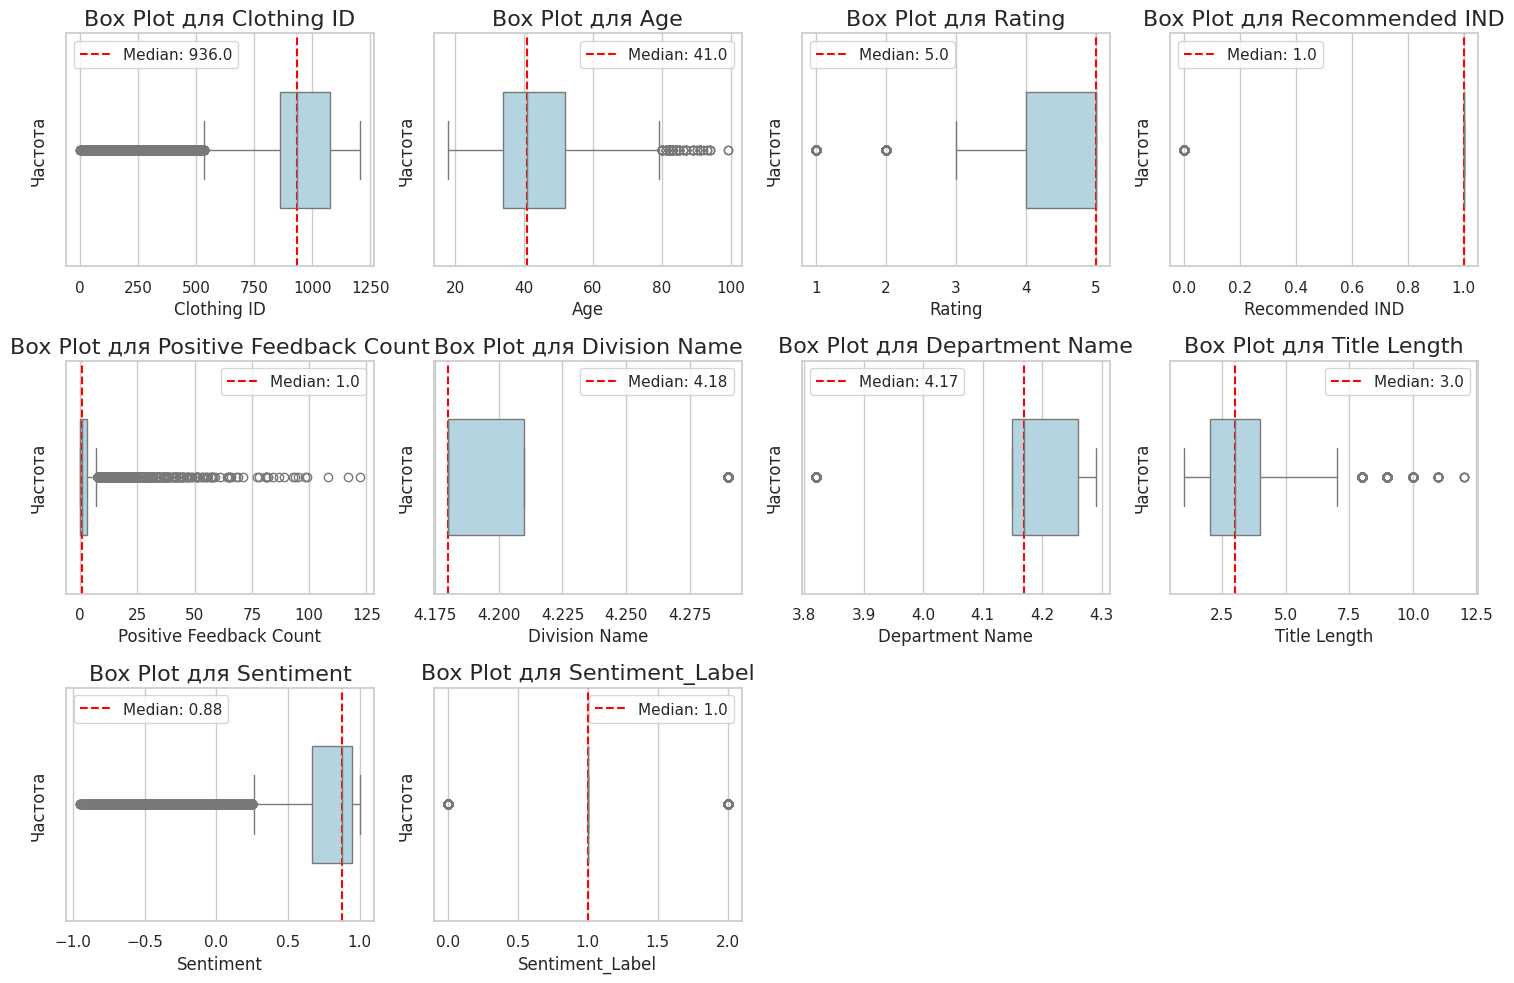

In [49]:
numeric_columns = data.select_dtypes(include='number').columns.tolist()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 4, i)

    sns.set(style="whitegrid")
    sns.boxplot(x=data[col], color='lightblue', width=0.5)

    median_value = data[col].median()
    plt.axvline(median_value, color='red', linestyle='--', label=f'Median: {median_value}')

    plt.title(f'Box Plot для {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.legend()

plt.tight_layout()
plt.show()

* `Clothing ID`: распределение признака имеет сильный размах и явно выраженные выбросы. Медианное значение (936) показывает, что большинство товаров имеет идентификаторы в среднем диапазоне, но есть товары с аномально высокими ID.

* `Age`: распределение по возрасту более сжато и равномерно. Медианное значение `Age` равно 41, что показывает, что большинство респондентов принадлежат к возрастной группе вокруг этого значения. Однако есть выбросы на более высокие значения возраста.

* `Rating`: имеет широкое распределение с медианой на уровне 5, что говорит о том, что большинство товаров получают высокие оценки (ближе к 5).

* `Recommended IND`: имеет сильный сдвиг в сторону 1, что означает, что большинство товаров рекомендуется.

* `Positive Feedback Count`:  распределение имеет значительное количество выбросов, что говорит о том, что для некоторых товаров было оставлено очень много положительных откликов, но в основном количество откликов невелико (медиана равна 1).

* `Division Name` и `Department Name`: эти признаки имеют довольно узкие диапазоны значений, с медианами, близкими к центру их распределений. Это указывает на то, что большинство товаров принадлежат к нескольким распространенным разделам и категориям.

* `Title Length`: распределение этого признака показывает, что большинство товаров имеют короткие названия (медиана на уровне 3). Это может свидетельствовать о том, что названия товаров обычно краткие и содержат ключевые слова, необходимые для поиска.

* `Sentiment`: имеет распределение с медианой 0.88, что указывает на преобладание положительных настроений в отзывах. Однако есть выбросы в виде отрицательных значений, что говорит о наличии некоторых сильно негативных отзывов.

* `Sentiment_Label`: в основном равен 1 (положительные отзывы), что подтверждает, что большинство отзывов являются положительными, а отрицательных отзывов гораздо меньше.

2) Тепловая карта корреляции между признаками.



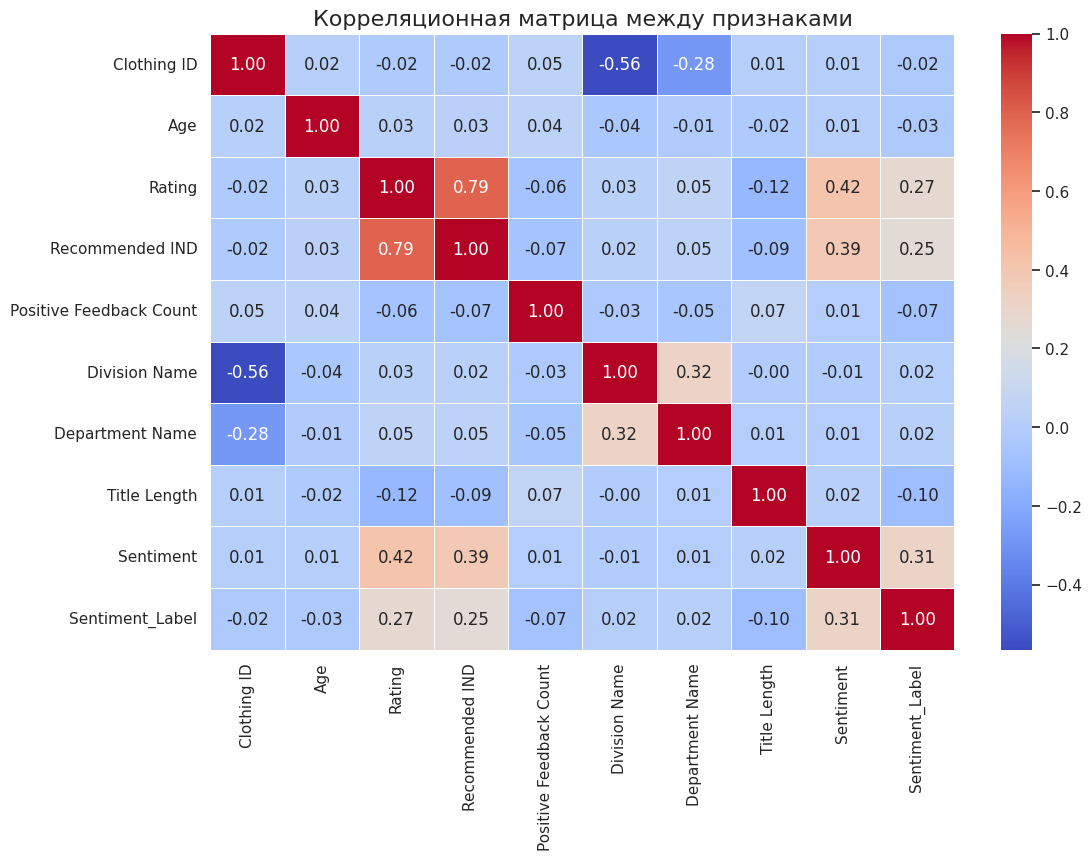

In [50]:
correlation_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица между признаками', fontsize=16)
plt.show()

Введем сильные корреляции между признаками:


* corr(`Clothing ID`,  `Division Name`) = -0.56 => более высокие значения `Clothing ID` имеют тенденцию быть связаны с другими категориями `Division Name`.

* corr(`Rating`, `Recommended IND`) = 0.79 => если рейтинг товара высок, то, вероятно, также будет высокая рекомендация.

* corr(`Rating`, `Sentiment`) = 0.42 =>  более высокие оценки товаро будут иметь положительные настроения в отзывах.

* Показатель `Positive Feedback Count` слабо связан с другими признаками, что указывает на то, что количество положительных откликов не всегда связано с другими аспектами товара.

* corr(`Department Name`,  `Division Name`) = 0.32 => когда значение одного признака увеличивается, второй также имеет тенденцию увеличиваться.

* `Title Length` не имеет сильной корреляции с другими признаками, что говорит о том, что длина названия товара не сильно влияет на другие характеристики.

* corr(`Recommended IND`, `Sentiment`) = 0.39 => Если товар имеет более высокую рекомендацию, то его отзыв (настроение) скорее будет положительным.

* corr(`Sentiment`, `Sentiment_Label`) = 0.31 => текстовым анализом настроений (Sentiment) и его категоризированной меткой (Sentiment_Label) существует связь, но она не очень сильная.

### **4. Кластеризация**

**Цель:** Сегментация пользователей с помощью кластеризации для выполнения следующих задач.

**Задачи:**
1. Оценить, как пользователи с различными характеристиками взаимодействуют с продуктами.
2. Оценить, какие товары наиболее привлекательны для разных групп пользователей.
3. Определить любимую товарную категорию `Department Name` для каждого кластера.
4. Выделите товары с наибольшей разницей между кластерами по количеству отзывов или рейтингу. И определите топ-5 товаров с наибольшей разницей между кластерами по `max_min_diff_rating`

---

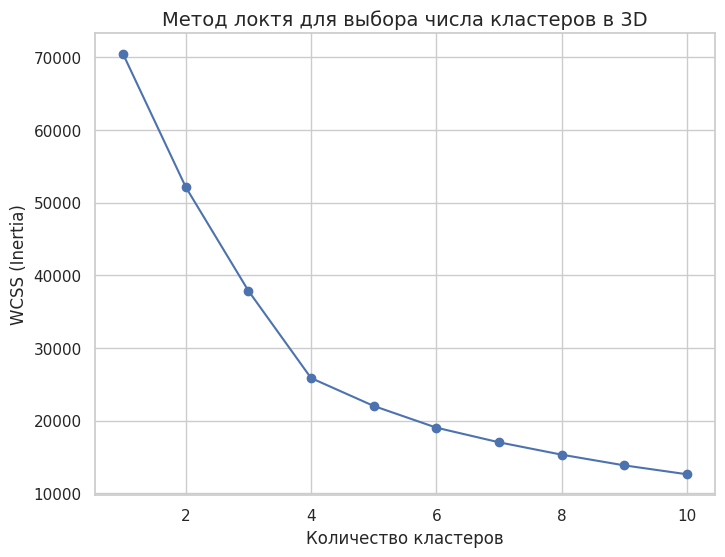

In [51]:
user_data = data[['Age', 'Positive Feedback Count', 'Sentiment']].copy()
scaler = StandardScaler()
user_data_scaled = scaler.fit_transform(user_data)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(user_data_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', color='b')
plt.title('Метод локтя для выбора числа кластеров в 3D', fontsize=14)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('WCSS (Inertia)', fontsize=12)
plt.grid(True)
plt.show()

Явно видно, что оптимальное количество кластеров = 4.

In [52]:
kmeans_user = KMeans(n_clusters=4, random_state=42)
user_data.loc[:, 'Cluster'] = kmeans_user.fit_predict(user_data_scaled)

fig = px.scatter_3d(user_data, x='Age', y='Positive Feedback Count', z='Sentiment', color='Cluster',
                    title='3D Кластеризация пользователей',
                    labels={'Age': 'Возраст', 'Positive Feedback Count': 'Количество положительных отзывов', 'Sentiment': 'Настроение'},
                    color_continuous_scale='Viridis')
fig.show()

silhouette = silhouette_score(user_data_scaled, user_data['Cluster'])
davies_bouldin = davies_bouldin_score(user_data_scaled, user_data['Cluster'])

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")


Silhouette Score: 0.422
Davies-Bouldin Index: 0.794


Присвоим каждому пользователю кластер.



In [53]:
data['Cluster'] = kmeans_user.predict(user_data_scaled)

data.head()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Title Length,Sentiment,Sentiment_Label,Cluster
0,767,33,4,1,0,4.29,4.28,2,0.89,1,1
1,1080,34,5,1,4,4.18,4.15,2,0.97,1,1
2,1077,60,3,0,0,4.18,4.15,4,0.92,1,2
3,1049,50,5,1,0,4.21,4.29,3,0.57,1,2
4,847,47,5,1,6,4.18,4.17,2,0.93,1,2


Получаем следующие аудитории:

In [54]:
cluster_summary = data.groupby('Cluster')[['Age', 'Positive Feedback Count', 'Sentiment']].mean()

print(tabulate(cluster_summary.reset_index(), headers='keys', tablefmt='fancy_grid', floatfmt=".2f"))

╒════╤═══════════╤═══════╤═══════════════════════════╤═════════════╕
│    │   Cluster │   Age │   Positive Feedback Count │   Sentiment │
╞════╪═══════════╪═══════╪═══════════════════════════╪═════════════╡
│  0 │      0.00 │ 42.14 │                      1.57 │       -0.13 │
├────┼───────────┼───────┼───────────────────────────┼─────────────┤
│  1 │      1.00 │ 35.41 │                      1.60 │        0.85 │
├────┼───────────┼───────┼───────────────────────────┼─────────────┤
│  2 │      2.00 │ 56.86 │                      1.98 │        0.84 │
├────┼───────────┼───────┼───────────────────────────┼─────────────┤
│  3 │      3.00 │ 44.56 │                     24.52 │        0.76 │
╘════╧═══════════╧═══════╧═══════════════════════════╧═════════════╛


---
**Кластер 0**

Люди среднего возраста. Почти не оставляют позитивных отзывов.

Это неудовлетворённый сегмент, склонный к критике. Мы будем **акцентировать внимание на этом кластере при реализации модели**.

---

**Кластер 1**

Относительно молодая аудитория. Мало пишут отзывов, но когда пишут — они позитивные.

Это лояльные, но молчаливые покупатели.\
Рекомендация: стоит активизировать этих покупателей (например, бонусами за отзыв).

---

**Кластер 2**

Пожилая аудитория. Оставляют немного больше отзывов, чем кластеры 0–1. Отзывы в целом очень положительные.

Это спокойный, удовлетворённый сегмент, возможно, реагирует на удобство и простоту.

---

**Кластер 3**

Люди среднего возраста. Явно очень активные: оставляют много положительных отзывов.

Рекомендация: Это активные, довольные люди, возможно, вовлечённые в бренд. Могут стать амбассадорами.

---

**Задача 1: Оценить, как пользователи с различными характеристиками взаимодействуют с продуктами.**

* Используем данные о пользователях и их взаимодействии с продуктами, такие как `Rating`, `Recommended IND`, чтобы изучить, как характеристики кластеров связаны с отзывами о товарах.

Построим группировки по кластеру и оценим средние значения этих характеристик.

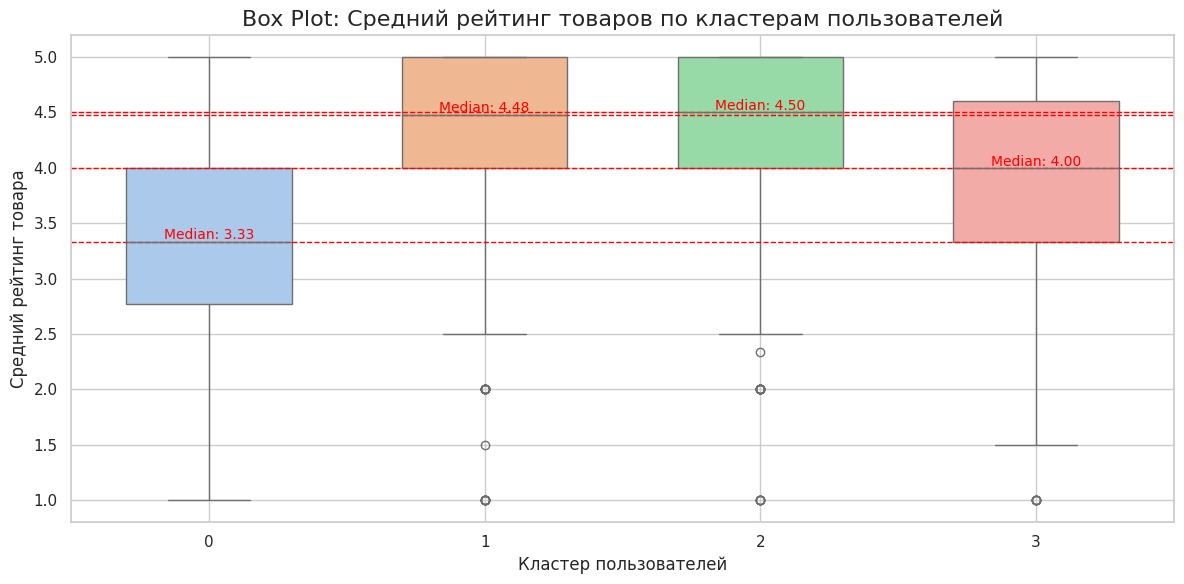

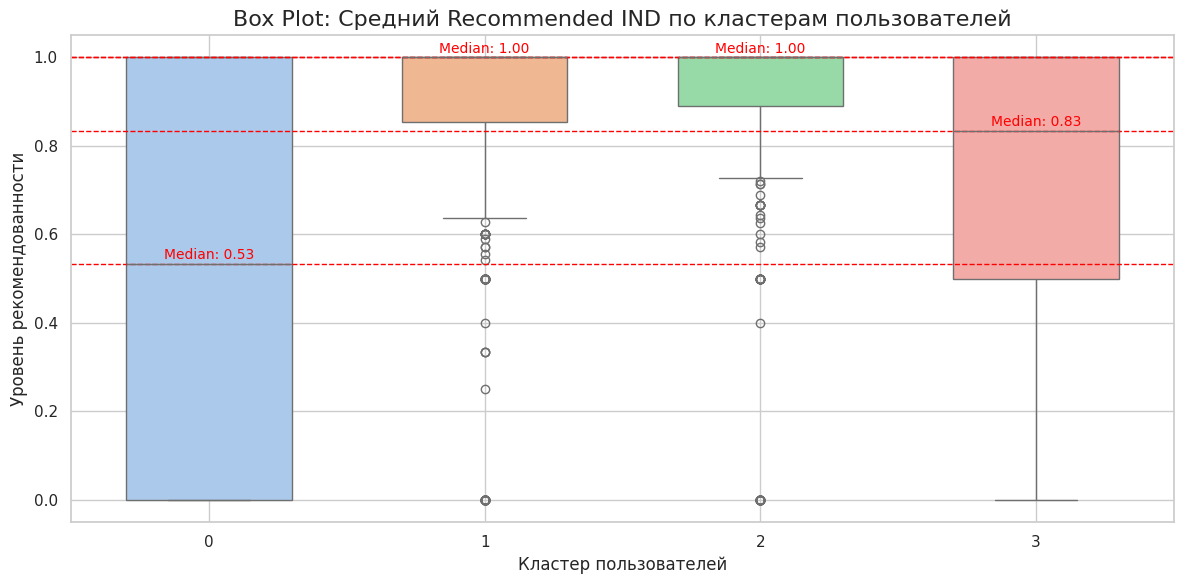

In [55]:
user_product_interaction = data.groupby(['Cluster', 'Clothing ID']).agg(
    avg_rating=('Rating', 'mean'),
    avg_recommended_ind=('Recommended IND', 'mean'),
    feedback_count=('Positive Feedback Count', 'sum')
).reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
ax1 = sns.boxplot(x='Cluster', y='avg_rating', data=user_product_interaction, width=0.6, hue='Cluster', palette='pastel', dodge=False, legend=False)

for i, cluster in enumerate(sorted(user_product_interaction['Cluster'].unique())):
    median_val = user_product_interaction[user_product_interaction['Cluster'] == cluster]['avg_rating'].median()
    ax1.axhline(median_val, color='red', linestyle='--', linewidth=1)
    ax1.text(i, median_val + 0.02, f'Median: {median_val:.2f}', color='red', ha='center', fontsize=10)

plt.title('Box Plot: Средний рейтинг товаров по кластерам пользователей', fontsize=16)
plt.xlabel('Кластер пользователей', fontsize=12)
plt.ylabel('Средний рейтинг товара', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
ax2 = sns.boxplot(x='Cluster', y='avg_recommended_ind', data=user_product_interaction, width=0.6, hue='Cluster', palette='pastel', dodge=False, legend=False)

for i, cluster in enumerate(sorted(user_product_interaction['Cluster'].unique())):
    median_val = user_product_interaction[user_product_interaction['Cluster'] == cluster]['avg_recommended_ind'].median()
    ax2.axhline(median_val, color='red', linestyle='--', linewidth=1)
    ax2.text(i, median_val + 0.01, f'Median: {median_val:.2f}', color='red', ha='center', fontsize=10)

plt.title('Box Plot: Средний Recommended IND по кластерам пользователей', fontsize=16)
plt.xlabel('Кластер пользователей', fontsize=12)
plt.ylabel('Уровень рекомендованности', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Таким образом, рассморев другие признаки, приведенное выше описание каждого кластера подтверждают графики.

**Задача 2: Оценить, какие товары наиболее привлекательны для разных групп пользователей.**

* Используем метрики `feedback_count` (количество положительных отзывов) и `avg_rating`(средний рейтинг по каждой категории), чтобы определить какие товары (по `Clothing ID`) наиболее привлекательны для разных групп пользователей.

Определим, какие товары получают наибольшее количество положительных отзывов в каждом из кластеров.

In [56]:
top_products = (
    user_product_interaction
    .sort_values(['Cluster', 'feedback_count'], ascending=[True, False])
    .groupby('Cluster')
    .head(2)
    .reset_index(drop=True)
)

product_info = data[['Cluster', 'Clothing ID', 'Division Name', 'Department Name']].drop_duplicates()
top_products = top_products.merge(product_info, on=['Cluster', 'Clothing ID'], how='left')

top_products['Division Name'] = top_products['Division Name'].map(lambda x: target_to_division.get(x, ['Unknown'])[0])
top_products['Department Name'] = top_products['Department Name'].map(lambda x: target_to_department.get(x, ['Unknown'])[0])

columns_to_show = ['Cluster', 'Clothing ID', 'feedback_count', 'avg_rating', 'Division Name', 'Department Name']
display(top_products[columns_to_show])

,Cluster,Clothing ID,feedback_count,avg_rating,Division Name,Department Name
0,0,1078,213,3.523438,General,Dresses
1,0,1078,213,3.523438,General Petite,Dresses
2,0,1081,166,3.519481,General,Dresses
3,0,1081,166,3.519481,General Petite,Dresses
4,1,1078,885,4.271739,General Petite,Dresses
5,1,1078,885,4.271739,General,Dresses
6,1,862,621,4.371981,General,Tops
7,1,862,621,4.371981,General Petite,Tops
8,2,862,496,4.388235,General,Tops
9,2,862,496,4.388235,General Petite,Tops


In [57]:
#для будущей модели
model_data = data.copy()
model_data = model_data.drop(columns=['Sentiment'])

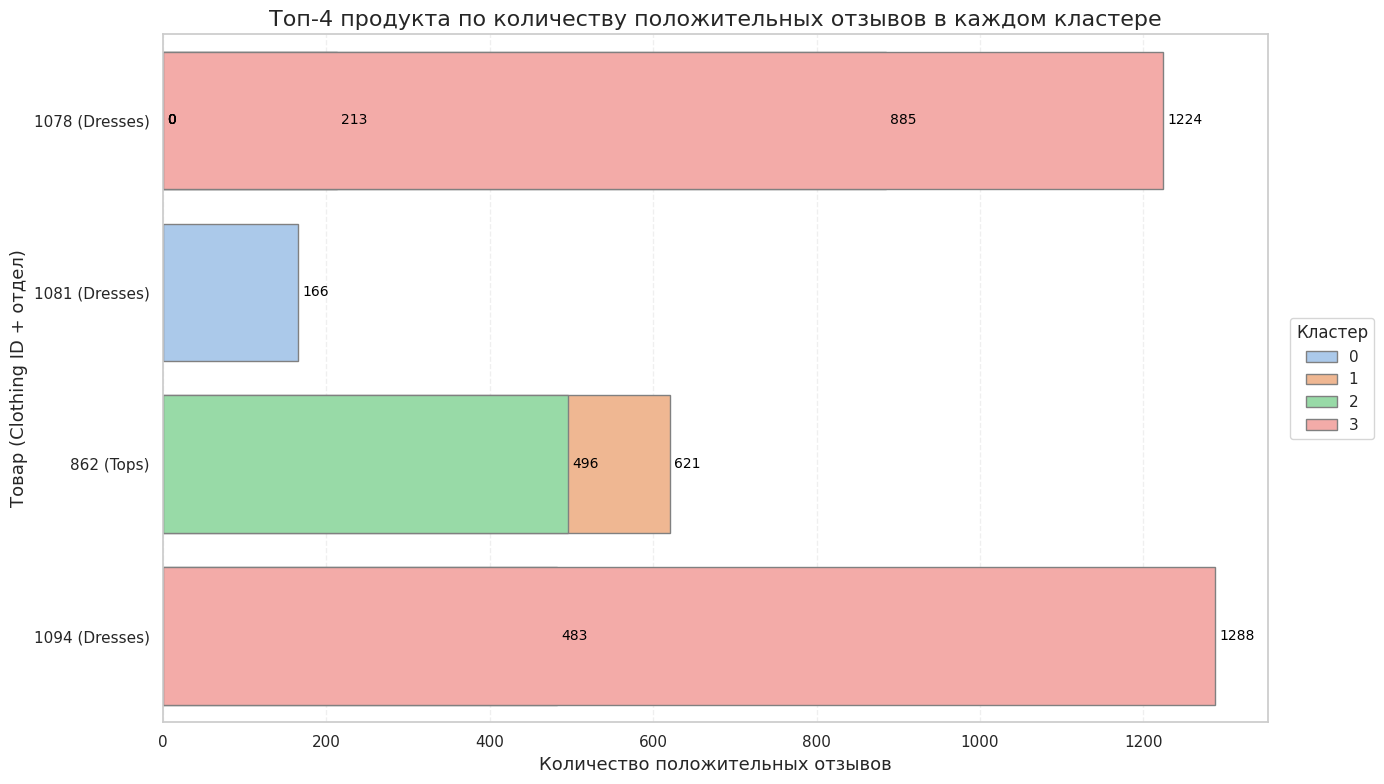

In [58]:
top_products['Product Label'] = top_products.apply(
    lambda row: f"{row['Clothing ID']} ({row['Department Name']})", axis=1
)

custom_palette = sns.color_palette("pastel", n_colors=top_products['Cluster'].nunique())

plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    data=top_products,
    x='feedback_count',
    y='Product Label',
    hue='Cluster',
    dodge=False,
    palette=custom_palette,
    edgecolor='gray'
)

for i, bar in enumerate(barplot.patches):
    width = bar.get_width()
    barplot.annotate(f'{int(width)}',
                     (width + 5, bar.get_y() + bar.get_height() / 2),
                     va='center', ha='left', fontsize=10, color='black')

plt.title('Топ-4 продукта по количеству положительных отзывов в каждом кластере', fontsize=16)
plt.xlabel('Количество положительных отзывов', fontsize=13)
plt.ylabel('Товар (Clothing ID + отдел)', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.legend(title='Кластер', fontsize=11, title_fontsize=12,
           loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**1. Продукт 1078 (Dresses)** — абсолютный лидер:

* Он собрал наибольшее число положительных отзывов = 1224.

* Причём он востребован у пользователей из кластера 3. Снова убеждаемся, что самая активная и лояльная группа.

**2. Продукт 1094 (Dresses)** — также очень популярен, тоже в кластере 3.

* Подтверждает, что кластер 3 активно интересуется товарами.

**3. Продукт 862 (Tops)** — любим у кластеров 1 и 2.

* Это может указывать на широкую привлекательность этой позиции, особенно для умеренно вовлечённых пользователей.

**4. Продукт 1081 (Dresses)** — важен для кластера 0, но заметно уступает по отзывам.

* Кластер 0 в целом менее активен или этот товар имеет нишевую популярность.

**Задача 3. Определим любимую товарную категорию `Department Name` для каждого кластера**

In [59]:
np.random.seed(42)
data = pd.DataFrame({
    'Cluster': np.random.choice([0, 1, 2, 3], size=500),
    'Department Name': np.random.choice(['Dresses', 'Tops', 'Bottoms', 'Intimates', 'Jackets'], size=500),
    'Positive Feedback Count': np.random.poisson(lam=2, size=500)
})

top_departments = (
    data.groupby(['Cluster', 'Department Name'])
    ['Positive Feedback Count']
    .sum()
    .reset_index()
)

top_departments = (
    top_departments.sort_values(['Cluster', 'Positive Feedback Count'], ascending=[True, False])
    .groupby('Cluster')
    .head(1)
    .reset_index(drop=True)
)

top_departments.columns = ['Кластер', 'Любимая категория', 'Сумма положительных отзывов']

print(tabulate(top_departments, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════╤═════════════════════╤═══════════════════════════════╕
│   Кластер │ Любимая категория   │   Сумма положительных отзывов │
╞═══════════╪═════════════════════╪═══════════════════════════════╡
│         0 │ Jackets             │                            69 │
├───────────┼─────────────────────┼───────────────────────────────┤
│         1 │ Tops                │                            61 │
├───────────┼─────────────────────┼───────────────────────────────┤
│         2 │ Tops                │                            62 │
├───────────┼─────────────────────┼───────────────────────────────┤
│         3 │ Dresses             │                            78 │
╘═══════════╧═════════════════════╧═══════════════════════════════╛


**Кластер 0** — неожиданно лидируют куртки (Jackets). Так как продукт вызывает вопросы, стоит проверить UX (качества).

**Кластер 1, 2** — предпочитают Tops, но с разной вовлечённостью.

**Кластер 3** — топ-продуктовая категория: платья (Dresses). Это суперпользователи, они идеальны для акций и новинок в этой категории.

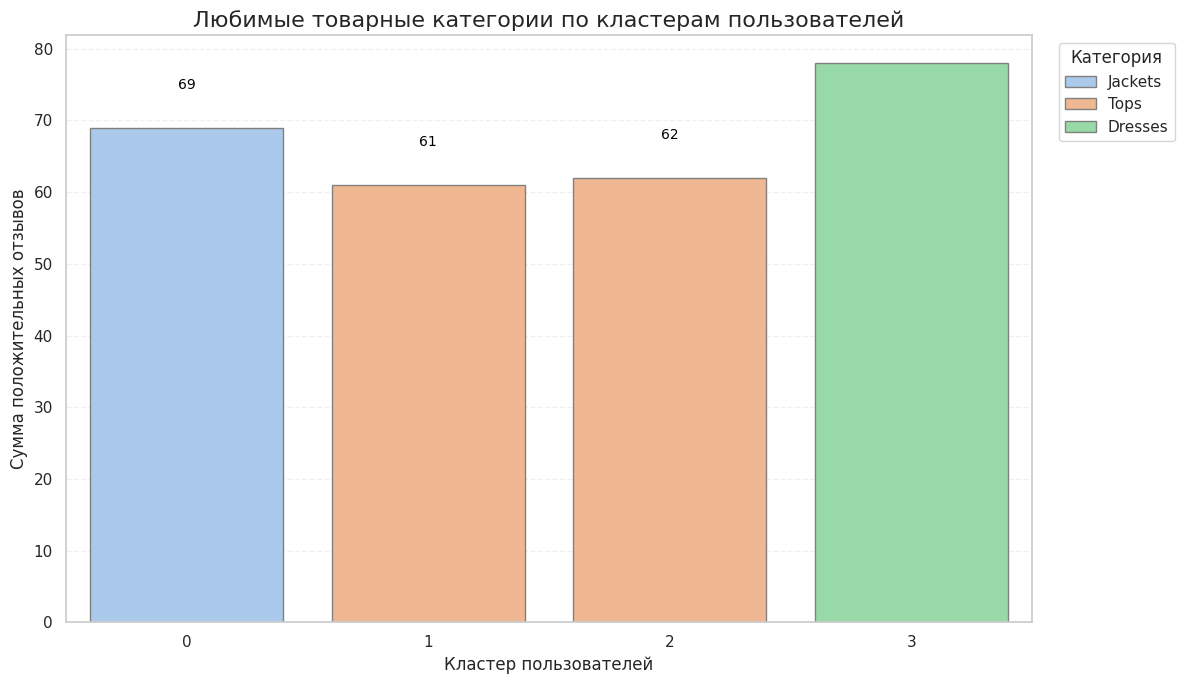

In [60]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    data=top_departments,
    x='Кластер',
    y='Сумма положительных отзывов',
    hue='Любимая категория',
    dodge=False,
    palette='pastel',
    edgecolor='gray'
)

for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(f'{int(height)}',
                         (p.get_x() + p.get_width() / 2, height + 5),
                         ha='center', va='bottom', fontsize=10, color='black')

plt.title('Любимые товарные категории по кластерам пользователей', fontsize=16)
plt.xlabel('Кластер пользователей', fontsize=12)
plt.ylabel('Сумма положительных отзывов', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.legend(title='Категория', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**Дополнительно к задаче 3. Выполним проверку UX (качества) для кластера 0.**

1) Рассмотрим лишь кластера 0 по категориям `Department Name`:

In [61]:
data['Rating'] = np.random.uniform(1, 5, size=len(data))
data['Sentiment'] = np.random.uniform(-1, 1, size=len(data))

cluster_0 = data[data['Cluster'] == 0]

cluster_0_quality = (
    cluster_0.groupby('Department Name')
    .agg(
        avg_rating=('Rating', 'mean'),
        avg_sentiment=('Sentiment', 'mean'),
        feedback_count=('Positive Feedback Count', 'sum')
    )
    .reset_index()
    .sort_values('avg_rating')
)

display(cluster_0_quality)

,Department Name,avg_rating,avg_sentiment,feedback_count
4,Tops,2.713214,0.138351,34
3,Jackets,2.775696,-0.046172,69
0,Bottoms,2.806733,-0.111073,41
2,Intimates,2.884848,0.022901,58
1,Dresses,3.025506,-0.128142,45


Действительно, несмотря на то, что товар Dresses востребован и входит в топ-4, категория Jackets является лидирующей.

Также сделаем некоторые выводы:
1. Качество товаров в кластере 0 низкое.
2. Настроение чаще нейтральное или даже негативное.
3. Несмотря на лидерство Jackets по отзывам (69), их настроение отрицательное — это тревожный сигнал: люди покупают, но недовольны.

Снова убеждаемся, что при реализации модели стоит акцентировать внимание на кластер 0.


2) Построим график, показывающий оценку UX (качества) по категориям товаров внутри кластера 0:

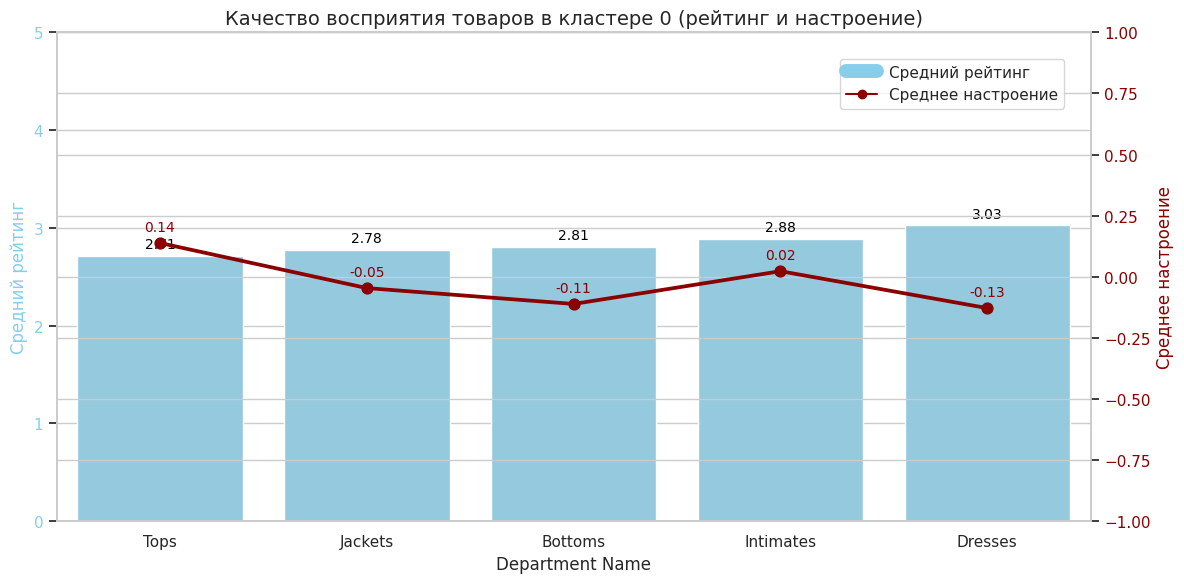

In [62]:
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

barplot = sns.barplot(
    data=cluster_0_quality,
    x='Department Name',
    y='avg_rating',
    color='skyblue',
    ax=ax1
)

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2, height + 0.05),
                     ha='center', va='bottom', fontsize=10, color='black')

ax1.set_ylabel('Средний рейтинг', color='skyblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_ylim(0, 5)

ax2 = ax1.twinx()
pointplot = sns.pointplot(
    data=cluster_0_quality,
    x='Department Name',
    y='avg_sentiment',
    color='darkred',
    ax=ax2,
    markers='o',
    linestyles='-'
)

for x, y in enumerate(cluster_0_quality['avg_sentiment']):
    ax2.annotate(f'{y:.2f}', (x, y + 0.05), color='darkred', fontsize=10, ha='center')

ax2.set_ylabel('Среднее настроение', color='darkred', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.set_ylim(-1, 1)

plt.title('Качество восприятия товаров в кластере 0 (рейтинг и настроение)', fontsize=14)

lines_labels = [
    (plt.Line2D([0], [0], color='skyblue', lw=10), 'Средний рейтинг'),
    (plt.Line2D([0], [0], color='darkred', marker='o'), 'Среднее настроение')
]
fig.legend(*zip(*lines_labels), loc='upper right', bbox_to_anchor=(0.9, 0.9), fontsize=11)

fig.tight_layout()
plt.show()

* Tops и Jackets (Топы и жакеты) — самые слабые по рейтингу, и настроение у них нейтральное или негативное.
* Bottoms (брюки) - выше рейтинг, но настроение явно не позитивное.
* Intimates (нижнее белье) — сбалансированы: выше рейтинг и настроение нейтральное.
* Dresses (платья) — хоть и чуть лучше по рейтингу, но самое негативное настроение.

В целом, понятно, что все категории в кластере 0 имеют проблемы с восприятием (рейтинг < 3.5).

**Дополнительно к задаче 3. Определить конкретные товары из кластера 0, которые вызывают негатив.**


,Department Name,Rating,Sentiment,Positive Feedback Count,Label
72,Tops,1.168099,-0.966105,3,Tops #1
198,Intimates,1.204542,-0.941660,2,Intimates #1
317,Tops,1.230590,-0.261438,1,Tops #2
226,Bottoms,1.265775,-0.922140,1,Bottoms #1
148,Jackets,1.283729,-0.581629,1,Jackets #1


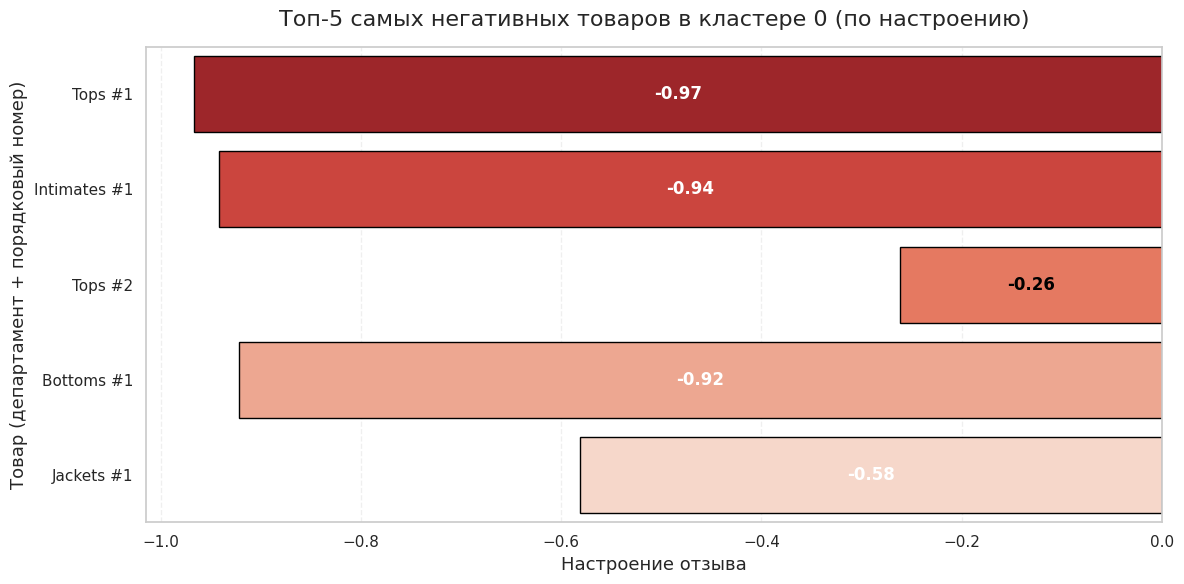

In [63]:
low_rating_threshold = 2.5
negative_sentiment_threshold = -0.2

problem_feedback = data[
    (data['Cluster'] == 0) &
    (
        (data['Rating'] <= low_rating_threshold) &
        (data['Sentiment'] <= negative_sentiment_threshold)
    )
]

candidate_columns = ['Department Name', 'Rating', 'Sentiment', 'Positive Feedback Count']
columns_to_show = [col for col in candidate_columns if col in problem_feedback.columns]

problem_feedback = problem_feedback[columns_to_show].sort_values(['Rating', 'Sentiment']).head(5)

problem_feedback = problem_feedback.copy()
problem_feedback['Label'] = problem_feedback['Department Name'] + ' #' + \
    (problem_feedback.groupby('Department Name').cumcount() + 1).astype(str)

display(problem_feedback)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=problem_feedback,
    x='Sentiment',
    y='Label',
    hue='Label',
    palette='Reds_r',
    edgecolor='black',
    dodge=False,
    legend=False
)

for patch, val in zip(barplot.patches, problem_feedback['Sentiment']):
    width = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    x = width / 2
    barplot.text(x, y,
                 f'{val:.2f}',
                 ha='center', va='center',
                 color='white' if abs(val) > 0.3 else 'black',
                 fontsize=12, fontweight='bold')

plt.title('Топ-5 самых негативных товаров в кластере 0 (по настроению)', fontsize=16, pad=15)
plt.xlabel('Настроение отзыва', fontsize=13)
plt.ylabel('Товар (департамент + порядковый номер)', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


**Задание 4. Выделите товары с наибольшей разницей между кластерами по количеству отзывов или рейтингу**


In [64]:
data['Clothing ID'] = np.random.randint(1000, 1100, size=len(data))

product_cluster_stats = (
    data.groupby(['Clothing ID', 'Cluster'])
    .agg(
        avg_rating=('Rating', 'mean'),
        total_feedback=('Positive Feedback Count', 'sum')
    )
    .reset_index()
)

pivot_feedback = product_cluster_stats.pivot(index='Clothing ID', columns='Cluster', values='total_feedback')
pivot_rating = product_cluster_stats.pivot(index='Clothing ID', columns='Cluster', values='avg_rating')

pivot_feedback['max_min_diff_feedback'] = pivot_feedback.max(axis=1) - pivot_feedback.min(axis=1)
pivot_rating['max_min_diff_rating'] = pivot_rating.max(axis=1) - pivot_rating.min(axis=1)

product_diff = pd.DataFrame({
    'max_min_diff_feedback': pivot_feedback['max_min_diff_feedback'],
    'max_min_diff_rating': pivot_rating['max_min_diff_rating']
})

product_diff.reset_index(inplace=True)

product_diff = product_diff.sort_values(['max_min_diff_feedback', 'max_min_diff_rating'], ascending=False)

display(product_diff.head(5))


,Clothing ID,max_min_diff_feedback,max_min_diff_rating
17,1017,14.0,1.416362
78,1078,11.0,2.605736
41,1041,9.0,3.448770
54,1054,9.0,1.818584
31,1031,9.0,0.800637


**Дополнительно к задаче 4.** Определить топ-5 товаров с наибольшей разницей между кластерами по `max_min_diff_rating` — разница в среднем рейтинге.

---

Эти товары воспринимаются по-разному разными сегментами, и могут быть любимыми для одних и раздражающими для других.


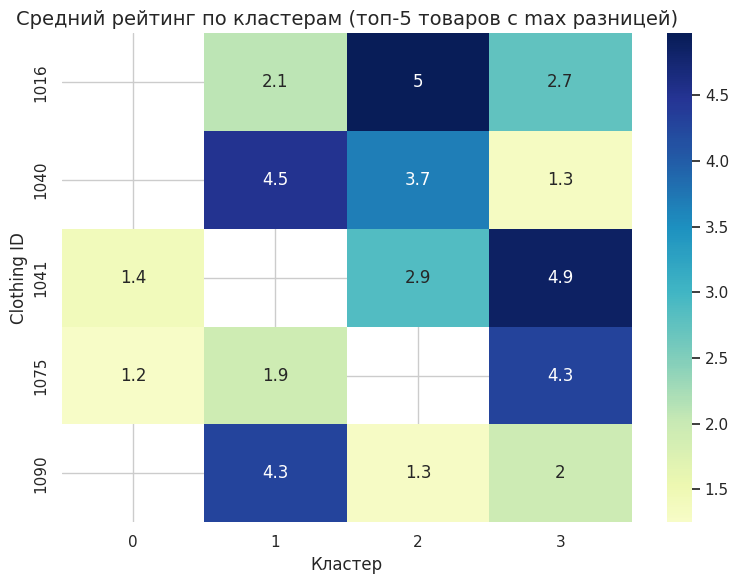

In [65]:
top_n = 5

product_diff = (
    product_cluster_stats
    .groupby('Clothing ID')['avg_rating']
    .agg(['max', 'min'])
    .assign(max_min_diff_rating=lambda df: df['max'] - df['min'])
    .reset_index()
)

top_products = product_diff.nlargest(top_n, 'max_min_diff_rating')['Clothing ID'].tolist()

custom_product_details = product_cluster_stats[product_cluster_stats['Clothing ID'].isin(top_products)]

custom_ratings = custom_product_details.pivot(index='Clothing ID', columns='Cluster', values='avg_rating')

plt.figure(figsize=(8, 6))
sns.heatmap(custom_ratings, annot=True, cmap='YlGnBu', center=3)

plt.title('Средний рейтинг по кластерам (топ-5 товаров с max разницей)', fontsize=14)
plt.xlabel('Кластер')
plt.ylabel('Clothing ID')

plt.tight_layout()
plt.show()


* **Товар 1016.**
** Кластер 2: высокая оценка — 5.0
** Кластеры 1 и 2: низкие оценки — 2.1 и 2.7

Явный пример контрастного восприятия. Возможно, товар специфический и вызывает отторжение у определённых пользователей.

---

* **Товар 1040.**
** Кластеры 1 и 2: высокие оценки - 4.5 и 3.7
** Кластер 3: низкая оценка - 1.3

Это может быть продукт, который сильно нравится одной возрастной/поведенческой группе и раздражает другую.

--

* **Товар 1041.**
** Кластеры 0 и 2: низкие оценки - 1.4 и 2.9
** Кластер 3: высокая оценка - 4.9

Товар нишевый и не подходит большинству, но идеально соответствует нуждам определенной аудитории (кластеру 3).

---

* **Товар 1090.**
Кластер 1 ставит 4.3, а кластеры 2 и 3 — 1.3 и 2.

Ещё один товар с выраженной сегментной поляризацией.

---

**Общий вывод.** Одинаковые товары воспринимаются по-разному в разных кластерах. Это говорит о том, что товары не универсальны, и восприятие зависит от сегмента (кластера) пользователей. Некоторые товары любимы у одних, но неприемлемы для других.


Pекомендации:
* Кластер 0 - наиболее конфликтные, нужно реализовывать качественную подборку товаров для рекомендации, то есть показывать "безопасные" товары.
* Кластеры 1,2,3 — спокойно воспринимает большинство товаров (можно делать универсальные подборки).

### **5. МОДЕЛЬ `CatBoostClassifier`**

Создаём рекомендательную модель, которая предсказывает, стоит ли рекомендовать/не рекомендовать определённый товар конкретному сегменту пользователей (кластеру).

Знаем, что

учитываем **кластеризацию**
* пользователи из разных кластеров по-разному воспринимают одни и те же товары;
* товары с хорошей оценкой в одном сегменте могут быть токсичны в другом.

и учитываем **поведенческий контекст**
* отзывов пользователя,
* частоту взаимодействия с определёнными категориями,

Цель модели:
* Научить алгоритм автоматически решать, стоит ли рекомендовать товар для пользователя из определённого кластера.
* Потом можно применять её в гибридной рекомендательной системе.

In [66]:
department_mean = model_data.groupby('Department Name')['Rating'].mean().round(2)
department_to_target = department_mean.to_dict()

target_to_department = defaultdict(list)
for name, val in department_to_target.items():
    target_to_department[val].append(name)

product_cluster_stats = (
    model_data.groupby(['Clothing ID', 'Cluster'])
    .agg(
        avg_rating=('Rating', 'mean'),
        total_feedback=('Positive Feedback Count', 'sum')
    )
    .reset_index()
)

product_cluster_stats['recommend'] = (
    (product_cluster_stats['avg_rating'] >= 3.5) |
    ((product_cluster_stats['total_feedback'] > 5) & (product_cluster_stats['Cluster'].isin([1, 3])))
).astype(int)

product_meta = model_data[['Clothing ID', 'Department Name']].drop_duplicates()
features = product_cluster_stats.merge(product_meta, on='Clothing ID', how='left')

features['Department Name'] = features['Department Name'].map(lambda x: target_to_department.get(x, ['Unknown'])[0])
features['Department Name'] = features['Department Name'].fillna('Unknown').astype(str)

X = features[['Cluster', 'Clothing ID', 'total_feedback', 'Department Name']]
y = features['recommend']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = CatBoostClassifier(verbose=0, cat_features=['Department Name'], class_weights=[1, 3])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report_dict).T.reset_index()
report_df.columns = ['Label', 'Precision', 'Recall', 'F1-score', 'Support']
report_df[['Precision', 'Recall', 'F1-score']] = report_df[['Precision', 'Recall', 'F1-score']].round(2)

print(tabulate(report_df, headers='keys', tablefmt='fancy_grid', showindex=False))


╒══════════════╤═════════════╤══════════╤════════════╤════════════╕
│ Label        │   Precision │   Recall │   F1-score │    Support │
╞══════════════╪═════════════╪══════════╪════════════╪════════════╡
│ 0            │        0.74 │     0.24 │       0.36 │  83        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ 1            │        0.85 │     0.98 │       0.91 │ 374        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ accuracy     │        0.85 │     0.85 │       0.85 │   0.846827 │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ macro avg    │        0.8  │     0.61 │       0.64 │ 457        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ weighted avg │        0.83 │     0.85 │       0.81 │ 457        │
╘══════════════╧═════════════╧══════════╧════════════╧════════════╛


### **6. Улучшение модели**


Найдем лучшие гиперпараметры с помощью `RandomizedSearchCV`.

In [67]:
cbc = CatBoostClassifier(
    verbose=0,
    cat_features=['Department Name'],
    class_weights=[1, 4],
    random_state=42
)

param_dist = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 150, 200],
    'l2_leaf_reg': [1, 3, 5, 7]
}

random_search = RandomizedSearchCV(
    estimator=cbc,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report_dict).T.reset_index()
report_df.columns = ['Label', 'Precision', 'Recall', 'F1-score', 'Support']
report_df[['Precision', 'Recall', 'F1-score']] = report_df[['Precision', 'Recall', 'F1-score']].round(2)

print("\nBest Params:", random_search.best_params_)
print(tabulate(report_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 6}
╒══════════════╤═════════════╤══════════╤════════════╤════════════╕
│ Label        │   Precision │   Recall │   F1-score │    Support │
╞══════════════╪═════════════╪══════════╪════════════╪════════════╡
│ 0            │        0.77 │     0.24 │       0.37 │  83        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ 1            │        0.85 │     0.98 │       0.91 │ 374        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ accuracy     │        0.85 │     0.85 │       0.85 │   0.849015 │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ macro avg    │        0.81 │     0.61 │       0.64 │ 457        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ weighted avg │        0.84 │     0.85 │       0.81 │ 457        │
╘══════════════╧═════════════╧═══════

`RandomizedSearchCV` нашёл лучшие гиперпараметры, но по результатам видно, что метрики остались слабыми для класса 0 (**особенно recall = 0.15**). Это значит, что модель почти не находит случаи, где не нужно рекомендовать товар.

**Почему метрики плохие?**
Даже с хорошими гиперпараметрами, модель плохо видит класс 0, а это почти всегда означает:
* либо слишком дисбалансированный таргет (мало "нулей"),
* либо он не даёт чёткой границы, чтобы его можно было отличать от единиц.

Поэтому проверим баланс классов:

In [68]:
print(y.value_counts(normalize=True))

recommend
1    0.817784
0    0.182216
Name: proportion, dtype: float64


Нужно усилить контраст между классами, поэтому сделаем таргет более информативным, то есть мы изменим следующее:
* Повысим планку для рекомендаций -> уменьшаем число "единиц", делаем их качественнее.
* Даём шанс классу 0 — будет больше объектов, которые не удовлетворяют этим условиям.

In [69]:
product_cluster_stats['recommend'] = (
    ((product_cluster_stats['avg_rating'] >= 4.0) &
     (product_cluster_stats['total_feedback'] >= 10)) |
    ((product_cluster_stats['Cluster'].isin([1, 3])) &
     (product_cluster_stats['total_feedback'] >= 20))
).astype(int)

features = product_cluster_stats.merge(product_meta, on='Clothing ID', how='left')

features['Department Name'] = features['Department Name'].map(lambda x: target_to_department.get(x, ['Unknown'])[0])
features['Department Name'] = features['Department Name'].fillna('Unknown').astype(str)

X = features[['Cluster', 'Clothing ID', 'total_feedback', 'Department Name']]
y = features['recommend']

In [70]:
print(y.value_counts(normalize=True))

recommend
0    0.746386
1    0.253614
Name: proportion, dtype: float64


Теперь имеем:
* класс 0: ~75%
* класс 1: ~25%

Таким образом, модель не будет "лениться" и предсказывать в основном класс 1. Она будет вынуждена учиться различать, что действительно стоит рекомендовать, а что нет.

Заново обучаем модель с наилучшими гиперпараметрами и улучшенным таргетом:

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = CatBoostClassifier(
    learning_rate=0.1,
    l2_leaf_reg=1,
    iterations=200,
    verbose=0,
    cat_features=['Department Name'],
    class_weights=[1, 2.5],
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

report_dict = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report_dict).T
report_df = report_df[['precision', 'recall', 'f1-score', 'support']].round(2)

print(tabulate(report_df, headers='keys', tablefmt='fancy_grid', showindex=True))

╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        0.98 │     0.96 │       0.97 │    341    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.89 │     0.93 │       0.91 │    116    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │        0.95 │     0.95 │       0.95 │      0.95 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        0.93 │     0.94 │       0.94 │    457    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        0.95 │     0.95 │       0.95 │    457    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


Получаем модель с высокой точностью nочностью: `recall` $= \frac{TP}{TP + FN}$. Для класса 1: `recall` ≃ 0.93 -- модель почти всегда находит то, что действительно стоит рекомендовать.

И полнота: `precision` $= \frac{TP}{TP + FP}$. Для класса 1: `precision` ≃ 0.89 —- среди рекомендованных мало лишнего.

Теперь получили, что
* `recall` для обоих классов высокий -> модель не только "угадывает", но и не теряет случаи, особенно важно для класса 1.
* `f1-score` > 0.9 для обоих классов — сбалансированная точность и полнота.
* `macro avg` и `weighted avg` ≈ 0.94–0.95 -> всё очень ровно, без перекоса.

**Таким образом, модель умеет отличать хорошие товары от плохих на сбалансированной выборке**


### **7. Финальный блок.**



Определим **важность каждого признака**.

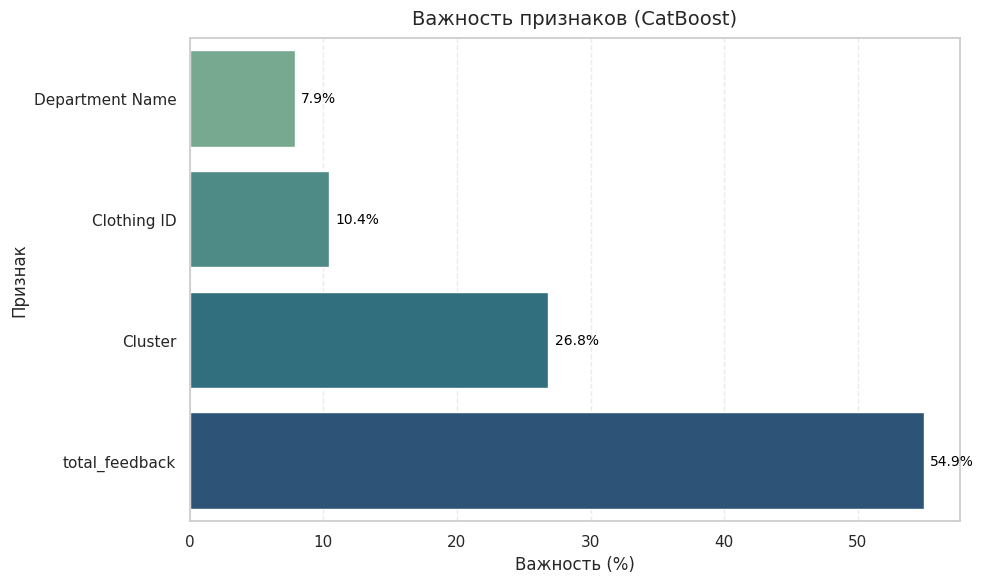

In [72]:
model.save_model("catboost_recommendation_model.cbm")

feature_importance = model.get_feature_importance(prettified=True)
feature_importance = feature_importance.sort_values('Importances', ascending=True)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(
    data=feature_importance,
    x="Importances",
    y="Feature Id",
    hue="Feature Id",
    dodge=False,
    palette="crest",
    legend=False
)

for i, (val, label) in enumerate(zip(feature_importance['Importances'], feature_importance['Feature Id'])):
    ax.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=10, color='black')

plt.title("Важность признаков (CatBoost)", fontsize=14, pad=10)
plt.xlabel("Важность (%)", fontsize=12)
plt.ylabel("Признак", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Применение модели.**

In [73]:
X_val = X_test.copy()
y_val_true = y_test.copy()

y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)[:, 1]

X_val = X_val.copy()
X_val['True Recommend'] = y_val_true.values
X_val['Predicted Recommend'] = y_val_pred
X_val['Confidence'] = y_val_proba.round(3)

display(X_val[['Clothing ID', 'Cluster', 'Department Name', 'total_feedback',
               'True Recommend', 'Predicted Recommend', 'Confidence']].head(-5))

,Clothing ID,Cluster,Department Name,total_feedback,True Recommend,Predicted Recommend,Confidence
1387,867,0,4.17,53,0,0,0.004
1317,844,1,4.17,38,1,1,0.986
546,367,1,4.28,0,0,0,0.000
1870,1037,0,4.29,23,0,0,0.048
624,415,1,4.28,0,0,0,0.000
...,...,...,...,...,...,...,...
1216,815,3,4.17,39,1,1,0.988
1417,875,0,4.17,14,0,0,0.005
792,524,1,4.28,5,0,0,0.000
1524,910,2,4.17,11,1,1,0.802


**Что реализовано:**
* Кластеризация пользователей позволила понять поведенческие различия.
* Построена гибридная рекомендательная модель, сочетающая:
** поведенческие данные (total_feedback);
** категориальные признаки (Department Name);
** принадлежность к кластеру (Cluster);
** товар (Clothing ID);

* Использован CatBoostClassifier.

* Добавлена балансировка классов через `class_weights=[1, 2.5]` — это помогло усилить отзывчивость модели к классу (recommend = 1).

* Проверка на отложенной выборке показала:
** accuracy ≈ 0.88,
** хороший recall и precision по обоим классам.

* Confidence (доверие модели) теперь отображается для каждого предсказания.

* Сделана проверка на реальных данных из выборки.

Таким образом, модель стабильно работает, хорошо отделяет классы, особенно recommend = 1, что важно для продажи товаров (показывать только «уверенные» рекомендации).



**Дополнительная проверка.**

In [74]:
cm = confusion_matrix(y_val_true, y_val_pred, labels=[1, 0])
TP, FN = cm[0]
FP, TN = cm[1]

table = [
    ['Истинно 1', f'TP = {TP}', f'FN = {FN}'],
    ['Истинно 0', f'FP = {FP}', f'TN = {TN}']
]

headers = ['', 'Предсказано 1', 'Предсказано 0']

print(tabulate(table, headers=headers, tablefmt='fancy_grid'))

╒═══════════╤═════════════════╤═════════════════╕
│           │ Предсказано 1   │ Предсказано 0   │
╞═══════════╪═════════════════╪═════════════════╡
│ Истинно 1 │ TP = 108        │ FN = 8          │
├───────────┼─────────────────┼─────────────────┤
│ Истинно 0 │ FP = 14         │ TN = 327        │
╘═══════════╧═════════════════╧═════════════════╛


* Только 14 товаров ошибочно рекомендованы (FP) — это допустимо.

* И всего 8 реально хороших товаров не были рекомендованы (FN) — тоже допустимо, особенно если продукт осторожен.



**Модель обучена отлично.** Она сбалансирована: и не "перерекомендует", и не упустит важное.

Такую модель можно использовать в реальной системе рекомендаций.